In [1]:
import dlc_practical_prologue as prologue
from modules import *
from helpers import *
import time
import numpy as np

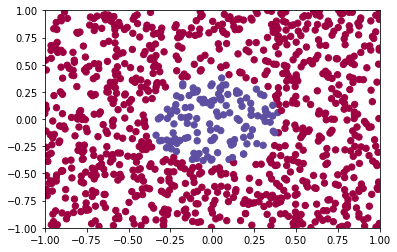

In [2]:
#generate disk data
N = 1000
train_input, train_target, test_input, test_target = generate_disk_data(nb_points=N)

fig = plt.figure()
plt.scatter(train_input[:, 0], train_input[:, 1], c=train_target, s=40, cmap=plt.cm.Spectral)
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.savefig("data")
plt.show()

In [3]:
#hyperparameters
step_size = 0.03
nb_epoch = 2000
batch_size = 100

# Model learning using MSE loss

Epoch       Time    Train loss     Train accuracy      Train F1 score 
[2000/2000] 21s     0.0059         99.6000             0.9844         
On train set:
Accuracy: 99.6
F1 score: 0.9844

On test set:
Accuracy: 98.2
F1 score: 0.9366
Time to train: 20.6940s


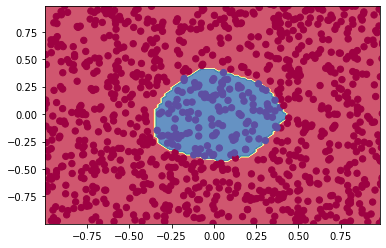

In [4]:
#model and criterion definition
model = Sequential(Linear(2,25), ReLU(), Linear(25,25),
                   ReLU(), Linear(25,25), ReLU(), Linear(25,2))
criterion = LossMSE()

#train the model
start_time = time.time()
train_model(model, criterion, train_input, train_target, nb_epoch, 
                batch_size, step_size, logging=True)
end_time = time.time()
print()
print("On test set:")
#evaluate the model
evaluate_model(model, test_input, test_target, logging=True)
print("Time to train: {0:.4f}s".format((end_time - start_time)))

# plot the classifiers
plot_classifier(model, train_input, train_target, save_name="MSELoss.png")

# Model learning using cross-entropy loss

Epoch       Time    Train loss     Train accuracy      Train F1 score 
[2000/2000] 33s     0.0005         100.0000            1.0000         
On train set:
Accuracy: 100.0
F1 score: 1.0000

On test set:
Accuracy: 98.7
F1 score: 0.9556
Time to train: 32.6860s


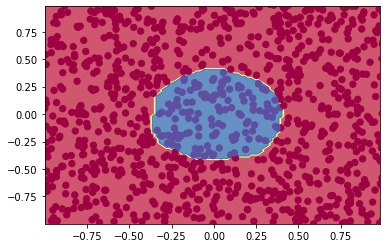

In [5]:
#model and criterion definition
model = Sequential(Linear(2,25), ReLU(), Linear(25,25),
                   ReLU(), Linear(25,25), ReLU(), Linear(25,2))
criterion = LossCrossEntropy()

#train the model
start_time = time.time()
train_model(model, criterion, train_input, train_target, nb_epoch, 
                batch_size, step_size, logging=True)
end_time = time.time()
print()
print("On test set:")
#evaluate the model
evaluate_model(model, test_input, test_target, logging=True)
print("Time to train: {0:.4f}s".format((end_time - start_time)))

# plot the classifiers
plot_classifier(model, train_input, train_target, save_name="CrossEntropyLoss")

# Run experiment several times for more accurate result

In [6]:
def repeat_experiment(loss, n=10):
    """
    Repeat the same training on the same 
    model using either cross entropy or MSE loss
    Finally display the average
    training time, the average F1 score and average accuracy
    
    Args:
    loss -- the loss to use as a string
    n -- the number of time to repeat the experiment
    """
    training_accs = []
    training_f1s = []
    testing_accs = []
    testing_f1s = []
    times = []

    for i in range(n):
        #model and criterion definition
        model = Sequential(Linear(2,25), ReLU(), Linear(25,25),
                       ReLU(), Linear(25,25), ReLU(), Linear(25,2))
        if loss == "MSE":
            criterion = LossMSE()
        elif loss == "CrossEntropy": 
            criterion = LossCrossEntropy()
        #train the model
        starting_time = time.time()
        training_acc, training_f1 = train_model(model, criterion, train_input, train_target, nb_epoch, 
                batch_size, step_size, logging=False)
        end_time = time.time()
        #evaluate the model
        testing_acc, testing_f1 = evaluate_model(model, test_input, test_target, logging=False)

        training_accs.append(training_acc)
        training_f1s.append(training_f1)
        testing_accs.append(testing_acc)
        testing_f1s.append(testing_f1)
        times.append(end_time-starting_time)

    training_mean_acc = np.array(training_accs).mean()
    training_mean_f1 = np.array(training_f1s).mean()
    testing_mean_acc = np.array(testing_accs).mean()
    testing_mean_f1 = np.array(testing_f1s).mean()
    avg_time = np.array(times).mean()

    print("Average training accuracy over {0} runs: {1}".format(n,training_mean_acc))
    print("Average training F1 score over {0} runs: {1}".format(n,training_mean_f1))
    print("Average testing accuracy over {0} runs: {1}".format(n,testing_mean_acc))
    print("Average testing F1 score over {0} runs: {1}".format(n,testing_mean_f1))
    print("Average time to train: {0:.4f}s".format(avg_time))

### MSE loss

In [7]:
repeat_experiment("MSE", n=10)

Average training accuracy over 10 runs: 99.69
Average training F1 score over 10 runs: 0.9878450266191872
Average testing accuracy over 10 runs: 98.2
Average testing F1 score over 10 runs: 0.936700461162518
Average time to train: 13.4984s


### Cross entropy loss

In [8]:
repeat_experiment("CrossEntropy", n=10)

Average training accuracy over 10 runs: 99.97
Average training F1 score over 10 runs: 0.9988326496138995
Average testing accuracy over 10 runs: 98.47999999999999
Average testing F1 score over 10 runs: 0.9480187237951325
Average time to train: 19.1439s


# Comparison with pytorch

In [9]:
import torch
import torch.nn as nn

def train_pytorch_model(model, criterion, train_input, train_target, test_input, test_target, 
                        nb_epoch, batch_size, step_size, logging=False):
    """Train the given model given according to the given criterion 
    and assess its performance on the training and testing data
    
    Args:
    model -- the model of type modules.Sequential to be trained
    criterion -- the criterion of type modules.Losses
    train_input -- tensor of input
    train_target -- tensor of target
    test_input -- tensor of input
    test_target -- tensor of target
    nb_eboch -- number of eboch 
    batch_size -- size of the mini batch
    step_size -- size of the step took by sgd at each iteration
    logging -- whether or not to print on the console the final performance of the model
    
    Returns:
    train_acc -- the accuracy of the model on the training data
    train_f1 -- the fscore of the model on the training data
    test_acc -- the accuracy of the model on the testing data
    test_f1 -- the fscore of the model on the testing data
    train_time -- the time needed to train the model in second
    """
   
    optimizer = torch.optim.SGD(model.parameters(), lr=step_size)

    # if the criterion is MSELoss, the train_target should be of same size
    # as the output of the model i.e. (N, 2) in the case of the Disk.
    # but train_target is expected to represent the target class for each input
    # and thus have a size of (N,1)
    if type(criterion) == torch.nn.modules.loss.MSELoss:
        temp = torch.empty(size=(train_target.size(0), 2))
        for idx in range(temp.size(0)):
            if train_target[idx] == 0:
                a = 0
                b = 1.
            else:
                a = 1.
                b = 0.
            temp[idx,0] = b
            temp[idx,1] = a
        train_target_ = temp.clone()
    else:
        train_target_ = train_target

    #train the model
    start_time = time.time()
    for e in range(nb_epoch):
        for input, target in zip(train_input.split(batch_size), 
                                train_target_.split(batch_size)):
            output = model(input)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    end_time = time.time()
    if logging:
        print("On train set:")
    #evaluate the model on train data
    train_acc, train_f1 = evaluate_model(model, train_input, train_target, logging=logging)
    if logging:
        print()
        print("On test set:")
    #evaluate the model on test data
    test_acc, test_f1 = evaluate_model(model, test_input, test_target, logging=logging)
    train_time = end_time - start_time
    if logging:
        print("Time to train: {0:.4f}s".format(train_time))
    if logging:
        # plot the classifiers
        torch.set_grad_enabled(False) #to avoid an error
        plot_classifier(model, train_input, train_target, save_name="pytorch_classifier.png")
        torch.set_grad_enabled(True)
    return train_acc, train_f1, test_acc, test_f1, train_time

In [10]:
def repeat_pytorch_experiment(loss, n=10):
    """
    Repeat the same training on the same 
    model using pytorch library and using either cross entropy or MSE loss.
    Finally display the average
    training time, the average F1 score and average accuracy
    
    Args:
    loss -- the loss to use as a string
    n -- the number of time to repeat the experiment
    """
    training_accs = []
    training_f1s = []
    testing_accs = []
    testing_f1s = []
    times = []
    for i in range(n):
        #model and criterion definition
        model = nn.Sequential(nn.Linear(2,25), nn.ReLU(), nn.Linear(25,25),
                               nn.ReLU(), nn.Linear(25,25), nn.ReLU(), nn.Linear(25,2))
        if loss == "MSE":
            criterion = nn.MSELoss()
        elif loss == "CrossEntropy":
            criterion = nn.CrossEntropyLoss()

        training_acc, training_f1, testing_acc, testing_f1, training_time = train_pytorch_model(model, criterion, train_input,
                                            train_target, test_input, test_target,
                                            nb_epoch, batch_size, step_size, logging=False)

        training_accs.append(training_acc)
        training_f1s.append(training_f1)
        testing_accs.append(testing_acc)
        testing_f1s.append(testing_f1)
        times.append(training_time)

    avg_time = np.array(times).mean()
    training_mean_acc = np.array(training_accs).mean()
    training_mean_f1=np.array(training_f1s).mean()
    testing_mean_acc = np.array(testing_accs).mean()
    testing_mean_f1=np.array(testing_f1s).mean()

    print("Average training accuracy over {0} runs: {1}".format(n,training_mean_acc))
    print("Average training F1 score over {0} runs: {1}".format(n,training_mean_f1))
    print("Average testing accuracy over {0} runs: {1}".format(n,testing_mean_acc))
    print("Average testing F1 score over {0} runs: {1}".format(n,testing_mean_f1))
    print("Average time to train: {0:.4f}s".format(avg_time))

### Pytorch cross entropy loss

In [11]:
repeat_pytorch_experiment("CrossEntropy", 10)

Average training accuracy over 10 runs: 100.0
Average training F1 score over 10 runs: 1.0
Average testing accuracy over 10 runs: 98.71000000000001
Average testing F1 score over 10 runs: 0.9559113514003845
Average time to train: 13.5891s


### Pytorch MSE loss

In [12]:
repeat_pytorch_experiment("MSE", 10)

Average training accuracy over 10 runs: 99.93
Average training F1 score over 10 runs: 0.997282250370984
Average testing accuracy over 10 runs: 98.34
Average testing F1 score over 10 runs: 0.9423808189182381
Average time to train: 12.3224s


# On MNIST

In [13]:
#generate the data
train_input, train_target, test_input, test_target = prologue.load_data(normalize=True)

print('train_input', train_input.size(), 'train_target', train_target.size())
print('test_input', test_input.size(), 'test_target', test_target.size())

* Using MNIST
** Reduce the data-set (use --full for the full thing)
** Use 10000 train and 10000 test samples
train_input torch.Size([10000, 784]) train_target torch.Size([10000])
test_input torch.Size([10000, 784]) test_target torch.Size([10000])


In [14]:
#hyperparameters
nb_epoch = 100
batch_size = 100
step_size = 0.02

### Using our framework

In [15]:
training_accs = []
testing_accs = []
times = []
n = 10
for i in range(n):
    #model and criterion definition
    model = Sequential(Linear(784,512), ReLU(), Linear(512,512),
                   ReLU(), Linear(512,512), ReLU(), Linear(512,10))
      

    criterion = LossCrossEntropy()
    #train the model
    starting_time = time.time()
    training_acc, _ = train_model(model, criterion, train_input, train_target, nb_epoch, 
                batch_size, step_size, logging=False)
    end_time = time.time()
    #evaluate the model
    testing_acc, _ = evaluate_model(model, test_input, test_target, logging=False)

    training_accs.append(training_acc)        
    testing_accs.append(testing_acc)
    times.append(end_time-starting_time)

training_mean_acc = np.array(training_accs).mean()
testing_mean_acc = np.array(testing_accs).mean()
avg_time = np.array(times).mean()

print("Average training accuracy over {0} runs: {1}".format(n,training_mean_acc))
print("Average testing accuracy over {0} runs: {1}".format(n,testing_mean_acc))
print("Average time to train: {0:.4f}s".format(avg_time))

Average training accuracy over 10 runs: 100.0
Average testing accuracy over 10 runs: 95.083
Average time to train: 96.4663s


### Using PyTorch

In [16]:
torch.set_grad_enabled(True)
training_accs = []
testing_accs = []
times = []
n = 10
for i in range(n):
    #model and criterion definition
    model = nn.Sequential(nn.Linear(784,512), nn.ReLU(), nn.Linear(512,512),
                   nn.ReLU(), nn.Linear(512,512), nn.ReLU(), nn.Linear(512,10))
      

    criterion = nn.CrossEntropyLoss()
    #train the model
    starting_time = time.time()
    training_acc, _, testing_acc, _, training_time = train_pytorch_model(model, criterion, train_input,
                                            train_target, test_input, test_target,
                                            nb_epoch, batch_size, step_size, logging=False)

    end_time = time.time()
    #evaluate the model

    training_accs.append(training_acc)        
    testing_accs.append(testing_acc)
    times.append(training_time)

training_mean_acc = np.array(training_accs).mean()
testing_mean_acc = np.array(testing_accs).mean()
avg_time = np.array(times).mean()

print("Average training accuracy over {0} runs: {1}".format(n,training_mean_acc))
print("Average testing accuracy over {0} runs: {1}".format(n,testing_mean_acc))
print("Average time to train: {0:.4f}s".format(avg_time))

Average training accuracy over 10 runs: 100.0
Average testing accuracy over 10 runs: 95.231
Average time to train: 112.4895s
